# Machine Learning - Practical 2

Names: {altendorf-luckhardt-wibergh}

In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy.linalg import inv

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.

In [2]:
file = 'Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

### Tasks 1.1: Dataset Exploration 

Let's start with a bit of exploration.

- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.

In [3]:
# data exploration
X_all.shape, t_all.shape, np.unique(t_all)

((105, 64), (105,), array([False,  True]))

Text(0, 0.5, 'values (maximum - minimum)')

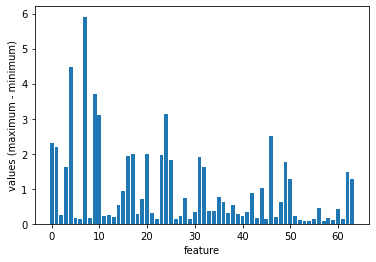

In [4]:
plt.bar(range(64),np.ptp(X_all,axis=0))
plt.xlabel("feature")
plt.ylabel("values (maximum - minimum)")

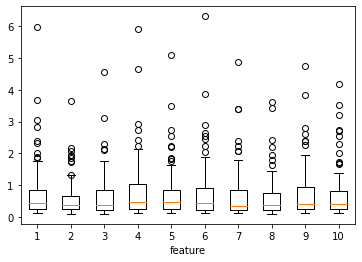

In [5]:
plt.boxplot(X_all[:10].T,labels=np.arange(1,11),vert=True)
plt.xlabel("feature")
plt.show()

Text(0, 0.5, 'variance')

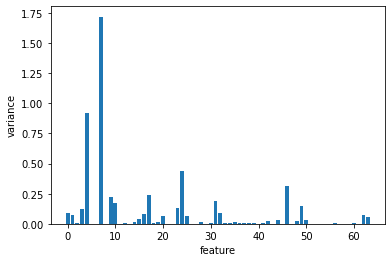

In [6]:
plt.bar(range(64),np.var(X_all,axis=0))
plt.xlabel("feature")
plt.ylabel("variance")

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [7]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # ---------------- INSERT CODE ----------------------
    test_len=(int)(np.array(y).shape[0]*.3)
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:test_len]
    train_idx = idx_shuffled[test_len:]

    X_test = X[test_idx]
    y_test = y[test_idx]
    X_train = X[train_idx]
    y_train = y[train_idx]


    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test
    
    
def preprocess(X, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # ---------------- INSERT CODE ----------------------
    for i in range(X.shape[1]):
        X[:,i]=(X[:,i]-X[:,i].mean())/X[:,i].std()


    # ---------------- END CODE -------------------------
    
    return X

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

### Task 2.1

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

Text(0.5, 0, 'predictors')

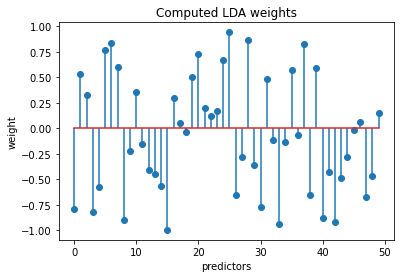

In [8]:
# example usage of stemplot
w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [9]:
def compute_lda_weights(x, y, alpha=0.001):
    '''function that computes regularized LDA weights for a two class problem

    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float

    output:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''

    # ---------------- INSERT CODE ----------------------
    m0 = x[y==0].mean(axis=0)
    m1 = x[y==1].mean(axis=0)
    mdiff = np.abs(m0-m1)
    #Sw = np.cov(x[y==0].T)+np.cov(x[y==1].T)
    Sw = (x[y==0]-m0).T@(x[y==0]-m0)+(x[y==1]-m1).T@(x[y==1]-m1)
    w = alpha*np.linalg.inv(Sw)@(m1-m0)
    # ---------------- END CODE -------------------------

    return m0, m1, mdiff, w

In [10]:
# split dataset and apply LDA
X_all=preprocess(X_all)
X_train, X_test, y_train, y_test = split_data(X_all,t_all)
m0, m1, mdiff, w = compute_lda_weights(X_train, y_train)

In [11]:
w.shape

(64,)

In [12]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((74, 64), (31, 64), (74,), (31,))

Text(0.5, 0, 'predictors')

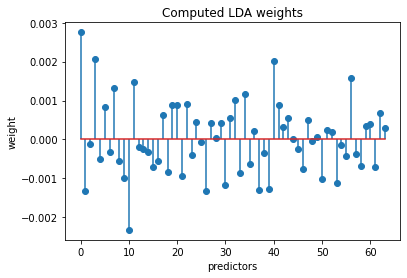

In [13]:
# visualize LDA weights using stemplot
plt.stem(w.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.2

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

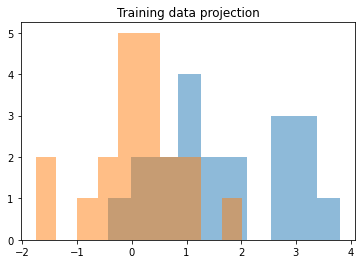

In [14]:
# example usage of histogram
a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

In [15]:
# compute projections for training and test data
proj_train = X_train@w
proj_test = X_test@w

In [16]:
proj_train.shape,X_train.shape

((74,), (74, 64))

In [17]:
proj_test[0]

-0.003558450388677703

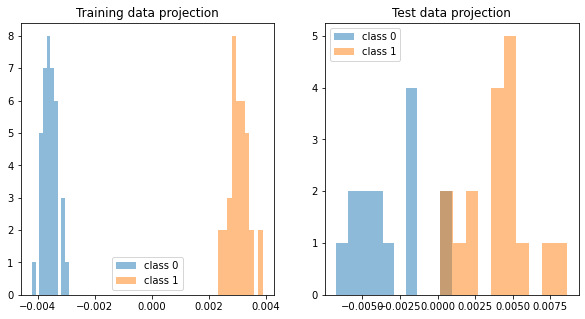

In [18]:
# visualize projections using histogram
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(proj_train[y_train==0],label='class 0',alpha=0.5)
axes[0].hist(proj_train[y_train==1],label='class 1',alpha=0.5)
axes[0].set_title('Training data projection')
axes[1].hist(proj_test[y_test==0],label='class 0',alpha=0.5)
axes[1].hist(proj_test[y_test==1],label='class 1',alpha=0.5)
axes[1].set_title('Test data projection')
axes[0].legend()
axes[1].legend()

- Is the class separation good?
    - It depends on seed and is not perfect, but you can see a trend of separation
- Is there a big difference between training and test data?
    - yes the difference is big, since the train data is separated very strongly

### Task 2.3

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [19]:
def compute_threshold_LDA(m0, m1, w):
    '''Compute the optimal threshold for LDA .

    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)

    output:
        c: the optimal threshold for LDA 
    '''

    # ---------------- INSERT CODE ----------------------
    c=w.T@(.5*(m0+m1))


    # ---------------- END CODE -------------------------
  
    return c


def score_LDA(x_proj, y, c):
    '''Compute the accuracy given a threshold.

    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar

    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        acc: classification accuracy
    '''
    # ---------------- INSERT CODE ----------------------
    y_hat=proj_test > c
    acc=np.mean(y==y_hat)

    # ---------------- END CODE -------------------------
    
    return y_hat, acc

In [20]:
# compute optimal threshold
c=compute_threshold_LDA(m0, m1, w)
c

-0.00025449291453774755

In [21]:
# compute classification accuracy
y_hat, acc=score_LDA(proj_test, y_test, c)
acc

0.9354838709677419

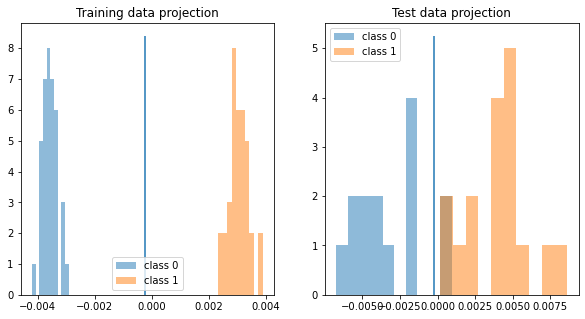

In [22]:
# visualize treshold in histogram
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(proj_train[y_train==0],label='class 0',alpha=0.5)
axes[0].hist(proj_train[y_train==1],label='class 1',alpha=0.5)
axes[0].set_title('Training data projection')
ymin, ymax = axes[0].get_ylim()
axes[0].vlines(c,ymin,ymax)
axes[1].hist(proj_test[y_test==0],label='class 0',alpha=0.5)
axes[1].hist(proj_test[y_test==1],label='class 1',alpha=0.5)
axes[1].set_title('Test data projection')
ymin, ymax = axes[1].get_ylim()
axes[1].vlines(c,ymin,ymax)
axes[0].legend()
axes[1].legend()

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [23]:
X_all, t_all = pickle.load(open('cnn_features.pickle', 'rb'))
X_all.shape

(2000, 256)

### Task 3.0: Normalize and split the data

Make sure the data has has zero mean and variance 1 per feature.

In [24]:
# normalize data
for i in range(X_all.shape[1]):
    X_all[:,i]=(X_all[:,i]-X_all[:,i].mean())/X_all[:,i].var()

### Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  

    Hints:  
    (a) There is a bias term in logistic regression  
    (b) Use a small value for weight init to avoid numerical problems.


2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [25]:
X_aug = np.hstack((np.ones((X_all.shape[0],1)),X_all))
X_train, X_test, y_train, y_test = split_data(X_aug,t_all)

In [26]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

In [27]:
# IRLS

def IRLS(w_old,X,t,n=10,TOL=.001):
    '''Computes Iterative Reweighted Least Squares.
            w_old = w_0 as start weights
            n = Max Number of Iterations
            TOL = Tolerance (Min Learning-rate)
    '''
    acc_old = 0
    for _ in range(n):
        y=sigmoid(X@w_old)
        y=y.reshape(-1)
        y_2=y-y**2
        w_old=w_old.reshape(-1)
        R=np.diag(y_2.reshape(-1))
        if(np.diag(R).mean()==0):
            break
        w_new = w_old -inv(X.T@R@X)@X.T@(y-t)
        y_pred = sigmoid(X@w_new) >.5
        y_pred = y_pred.astype(int)
        acc=np.mean(t==y_pred)
        print(acc)
        if(acc==1 or (acc-acc_old)<TOL):
            break
        acc_old = acc  
        w_old=w_new
    return w_new
    

In [28]:
w_int = .01*np.ones((X_train.shape[1],1))
w_new = IRLS(w_int,X_train,y_train)
y_pred = X_test@w_new>.5
y_pred = y_pred.astype(int)
np.mean(y_test==y_pred)

0.9557142857142857
0.9621428571428572
0.97
0.9835714285714285
0.995
1.0


0.8783333333333333

In [29]:
clf3 = LogisticRegression(penalty='none').fit(X_train, y_train)
coefs_noreg = clf3.coef_
clf3.score(X_test, y_test),clf3.score(X_train, y_train)

(0.895, 1.0)

### Task 3.2: Logistic Regression with Regularization

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [30]:
import warnings
warnings.filterwarnings('ignore')
Cs = np.linspace(0.02, 1, 25)
scores=np.zeros((25,2))
coefsl1 = []
coefsl2 = []
for ind ,c in enumerate(Cs):
    clf = LogisticRegression(penalty='l1',C=c,solver="saga").fit(X_train, y_train)
    coefsl1.append(clf.coef_)
    scores[ind,0]=clf.score(X_test, y_test)
    clf1 = LogisticRegression(penalty='l2',C=c).fit(X_train, y_train)
    coefsl2.append(clf1.coef_)
    scores[ind,1]=clf1.score(X_test, y_test)

In [31]:
coefsl1=np.array(coefsl1).reshape(25,257)
coefsl2=np.array(coefsl2).reshape(25,257)
coefsl1.shape

(25, 257)

Text(0.5, 0.98, 'strength of regularization')

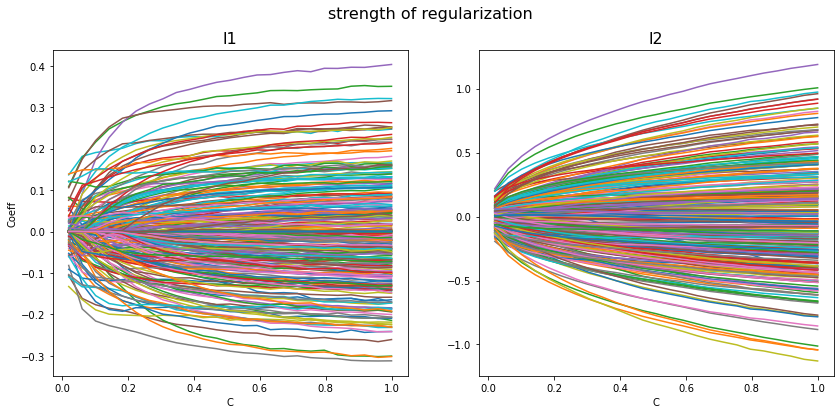

In [32]:
# Reg is strongest for smaller C
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
ax[0].plot(Cs,coefsl1)
ax[1].plot(Cs,coefsl2)
ax[0].set_xlabel("C")
ax[1].set_xlabel("C")
ax[0].set_title('l1',fontsize=16)
ax[1].set_title('l2',fontsize=16)
ax[0].set_ylabel("Coeff")
fig.suptitle("strength of regularization",fontsize=16)

Text(0.5, 0.98, 'strength of regularization over accuracy')

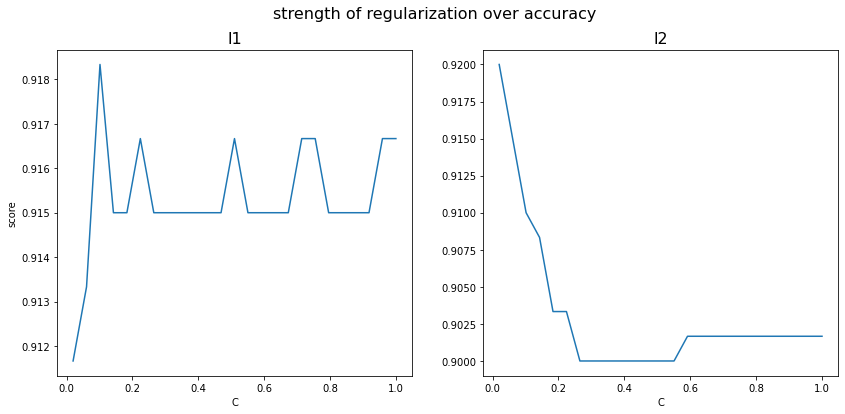

In [33]:
# yes strength increases score
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(Cs,scores[:,0])
ax[1].plot(Cs,scores[:,1])
ax[0].set_xlabel("C")
ax[0].set_title('l1',fontsize=16)
ax[1].set_title('l2',fontsize=16)
ax[1].set_xlabel("C")
ax[0].set_ylabel("score")
fig.suptitle("strength of regularization over accuracy",fontsize=16)

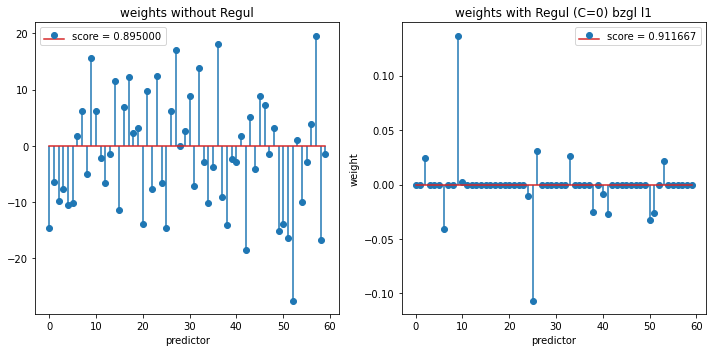

In [34]:
# weights with Reg are way smaller but way better score
# most of the weights are 0 and just a few at .15
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stem(coefs_noreg[:,:60].flatten(), use_line_collection=True,label="score = %f" %(clf3.score(X_test, y_test)))
ax[1].stem(coefsl1[0,:60].flatten(), use_line_collection=True,label="score = %f" %(scores[0,0]))
ax[0].set_xlabel("predictor")
ax[1].set_xlabel("predictor")
ax[0].set_title('weights without Regul')
ax[1].set_title('weights with Regul (C=0) bzgl l1')
plt.ylabel('weight')
plt.tight_layout()
ax[0].legend()
ax[1].legend()

In [35]:
# LDA weights has more peaks and less on 0